In [1]:
!pip install numpy seaborn tqdm

In [1]:
import polars as pl
import hashlib
import random 
import numpy as np
from steganodf.algorithms import BitPool
from reedsolo import RSCodec
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import string
from tqdm import tqdm
import concurrent.futures
%load_ext autoreload
%autoreload 2

## Chargement du dataset

In [2]:
bigdf = pl.read_csv("heart_attack_predictions.csv")

## Capacité

In [3]:
bigdf

Country,Age,Gender,Cholesterol_Level,Blood_Pressure,Smoking_History,Alcohol_Consumption,Physical_Activity,Obesity,Diabetes,Family_History,Stress_Levels,Dietary_Habits,Heart_Attack_History,Chest_Pain,Exercise_Induced_Angina,Resting_ECG,Max_Heart_Rate_Achieved,Thalassemia,HDL_Cholesterol,LDL_Cholesterol,Triglycerides,Heart_Disease_Risk,Medication_Adherence,Urbanization_Level,Air_Pollution_Exposure,Access_To_Healthcare,Education_Level,Income_Level,Heart_Attack_Outcome
str,i64,str,f64,f64,str,f64,str,str,str,str,f64,str,str,str,str,str,i64,str,f64,f64,f64,str,str,str,f64,str,str,str,str
"""Germany""",39,"""Male""",210.091036,173.30165,"""Never""",0.531933,"""Active""","""No""","""No""","""Yes""",3.559035,"""Healthy""","""Yes""","""Yes""","""Yes""","""Abnormal""",170,"""Reversible Defect""",96.545522,68.333573,165.060897,"""Medium""","""No""","""Urban""",51.988416,"""Good""","""Tertiary""","""Low""","""Died"""
"""Egypt""",88,"""Male""",163.99873,137.381678,"""Former""",5.626668,"""Sedentary""","""Yes""","""Yes""","""No""",6.193047,"""Moderate""","""Yes""","""No""","""Yes""","""Normal""",155,"""Reversible Defect""",92.524644,98.194015,452.124651,"""Medium""","""No""","""Suburban""",97.739896,"""Good""","""None""","""Low""","""Died"""
"""Spain""",60,"""Female""",263.50259,139.737677,"""Former""",0.928015,"""Active""","""No""","""Yes""","""No""",4.964536,"""Moderate""","""Yes""","""No""","""Yes""","""Normal""",114,"""Normal""",71.541637,118.767677,171.43262,"""Low""","""No""","""Urban""",60.352793,"""Poor""","""Tertiary""","""Low""","""Survived"""
"""Canada""",25,"""Female""",292.003927,85.992807,"""Former""",7.374519,"""Active""","""No""","""Yes""","""Yes""",4.14137,"""Moderate""","""Yes""","""Yes""","""No""","""Abnormal""",123,"""Normal""",41.99085,190.190597,329.553258,"""Medium""","""No""","""Urban""",14.397347,"""Good""","""Secondary""","""High""","""Survived"""
"""France""",54,"""Female""",267.736563,119.882856,"""Former""",4.317845,"""Sedentary""","""Yes""","""No""","""No""",9.957839,"""Unhealthy""","""No""","""Yes""","""Yes""","""Abnormal""",195,"""Reversible Defect""",82.890209,188.209372,449.953074,"""High""","""Yes""","""Rural""",69.448684,"""Good""","""None""","""Low""","""Died"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Philippines""",31,"""Female""",253.017629,154.701407,"""Never""",3.847926,"""Active""","""No""","""No""","""No""",3.26329,"""Unhealthy""","""Yes""","""No""","""Yes""","""Normal""",95,"""Fixed Defect""",72.889563,163.695385,396.604078,"""Medium""","""No""","""Suburban""",73.857917,"""Good""","""None""","""High""","""Died"""
"""India""",80,"""Male""",298.391575,114.793879,"""Never""",6.953435,"""Moderate""","""Yes""","""Yes""","""No""",5.877266,"""Unhealthy""","""Yes""","""Yes""","""Yes""","""Abnormal""",158,"""Fixed Defect""",86.741939,108.919452,99.136626,"""High""","""Yes""","""Urban""",67.599275,"""Good""","""Secondary""","""High""","""Died"""
"""Indonesia""",32,"""Female""",179.284857,163.986008,"""Former""",1.968123,"""Sedentary""","""No""","""No""","""Yes""",5.907898,"""Moderate""","""Yes""","""Yes""","""No""","""Normal""",190,"""Reversible Defect""",23.528468,96.376682,95.695854,"""Medium""","""No""","""Rural""",61.289874,"""Average""","""Primary""","""Medium""","""Survived"""


In [5]:
def gen(size:int):
    payload = [string.ascii_letters[i % len(string.ascii_letters)] for i in range(size)]
    payload ="".join(payload).encode()
    return payload

gen(10)

b'abcdefghij'

In [6]:
def estimate(algo, df):
    """ 
    estime la capacité max d'un df
    """
    max_size = []
    mmax = 0    
    index = 1
    while True:
        i = index % len(string.ascii_letters)
        payload = string.ascii_letters[:index]
        payload = payload.encode()
        encoded_df = algo.encode(df, payload)

        if algo.decode(encoded_df) == payload:
            mmax = index
            index+=1
        else:
            break

    return mmax

    


In [7]:
def find_max_payload(algo:BitPool, df):
    """ dichomie """

    def test(i):
        payload = gen(i)
        encoded_df = algo.encode(df, payload)
        return algo.decode(encoded_df) == payload

    left = 10
    right = int(algo.get_max_theoretical_payload_size(df)) 
    while True:
        mid = (left + right) // 2
        if not test(mid):  # Si True, on doit chercher dans la partie inférieure
            right = mid
        else:  # Si False, on cherche dans la partie supérieure
            left = mid + 1

        if abs(left-right) == 1 or left == right:
            break
    
    return left
    

a = BitPool(bit_per_row=1, parity_size=0, block_size=10)

print("A", find_max_payload(a, bigdf.head(2000)))
print("B", estimate(a , bigdf.head(2000)))

print("=============")
p = gen(40)
sdf = a.encode(bigdf.head(2000), p)

a.decode(sdf) == p


A 75
B 30


True

In [131]:
results = []



for s in tqdm(range(0, 20000,100)):
    for b in (5,10, 15, 20, 25):
        a = BitPool(bit_per_row=1, correction_size=0, data_size=b)
        sdf = bigdf.head(s)
        ss = []
        for i in range(4):
            size = find_max_payload(a, sdf)
            results.append({"total": s, "payload": size, "bloc_size": b, "pmax": a.get_max_payload_size(sdf) })

        
df = pl.DataFrame(results)
df.write_parquet("capacity5.parquet")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [2:08:47<00:00, 38.64s/it]


In [ ]:
ddf= pl.DataFrame(results)
ddf.write_parquet("capacity3.parquet")
ddf = ddf.filter(pl.col("total") > 1000)

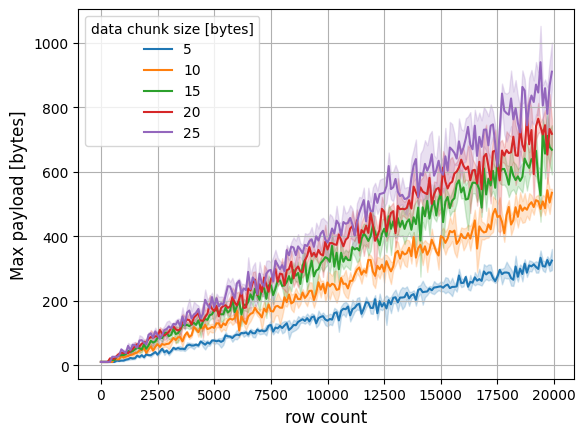

In [24]:
#ddf= pl.DataFrame(results)
#ddf.write_parquet("capacity2.parquet")
#ddf = ddf.filter(pl.col("total") > 1000)

ddf = pl.read_parquet("capacity5.parquet")
ddf = ddf.with_columns(pl.col("bloc_size").cast(pl.String()).alias("bloc"))

ax = sns.lineplot(x="total", y="payload", hue="bloc", data=ddf)
#ax2 = sns.lineplot(x="total", y="pmax", hue="bloc", c="gray", marker="", data=ddf)

plt.xlabel("row count", fontsize=12)
plt.ylabel("Max payload [bytes]", fontsize=12)
plt.legend(title="data chunk size [bytes]")
#plt.title("Max payload size as a function of row count")
plt.grid(True)
#plt.legend([],[], frameon=False)

# for b in (5,10, 15, 20, 25): 
#     a = BitPool(bit_per_row=1, correction_size=0, data_size=b)
#     x = np.linspace(0,20000)
#     total = x / 8 / 1.85
#     count = total / a.get_packet_size()
#     y = b * count
#     plt.plot(x,y)

# c = maxx // ( 12 + b + 4 + 10) 
# y = (x/8 ) / ( 12 + b + 4 + 10)  * b

    
  

In [90]:
8*126

1008

In [108]:
import numpy as np 
tdf = []
regdf = pl.read_parquet("capacity5.parquet")

for g in regdf["bloc_size"].unique():
    subset = regdf.filter(pl.col("bloc_size") == g)
    y = subset["payload"].to_list()
    x = subset["total"].to_list()

    a,b = np.polyfit(x,y, 1)

    a = np.dot(x,y) / np.dot(x,x)

    e = ( g / ( 1008 + 8* g) * 2)
   
    tdf.append({"g":g, "a": a, "b":b, "e": e})

tdf = pl.DataFrame(tdf)
tdf

g,a,b,e
i64,f64,f64,f64
5,0.014858,4.092353,0.009542
6,0.016715,4.205882,0.011364
7,0.019318,2.934706,0.013158
8,0.020542,1.188824,0.014925
9,0.022498,4.615882,0.016667
…,…,…,…
25,0.039543,2.254706,0.041391
26,0.036465,5.086471,0.042763
27,0.040522,6.915882,0.044118


<Axes: xlabel='g', ylabel='a'>

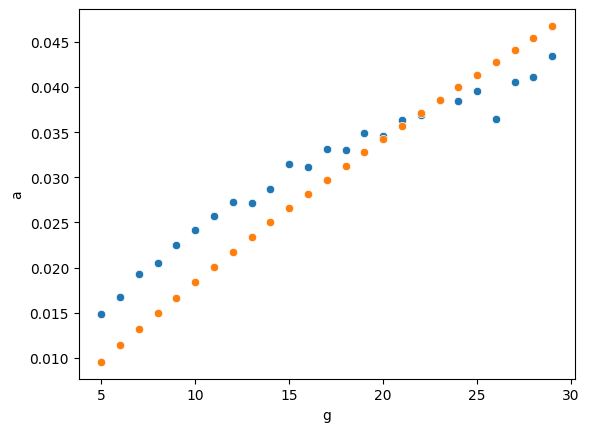

In [109]:
sns.scatterplot(x="g", y="a", data=tdf)
sns.scatterplot(x="g", y="e", data=tdf)
                              

In [143]:
p = gen(80)
a = BitPool(bit_per_row=1, parity_size=0, data_size=10)

sdf = a.encode(bigdf.head(4000), p)

a.decode(sdf) == p


False

## Croping

In [231]:
def find_max_crop_size(algo, df, payload):
    """ dichomie """

    left = 0
    right = len(df)
    while True:
        middle = (left + right) // 2
        stego_data = algo.decode(df[:middle])
     
        if stego_data != payload:
            left = middle + 1
        else:
            right = middle

        if abs(left-right) == 1 or left == right:
            break

    return right

# payload = gen(64)
# algo = BitPool(correction_size=10)
# print("encode")
# stego_df = algo.encode(bigdf, payload)

# print(payload)
# algo.decode(stego_df)
#print("find max")
#find_max_crop_size(algo, stego_df, payload)

In [249]:
def create_error(mdf, percent):
    
    df_encoded = mdf.to_pandas().copy()
 
    count = len(df_encoded) * percent // 100
    if count == 0:
        return mdf

    count = int(count)
    idx = random.sample(range(len(df_encoded)), k = count)
    df_encoded.iloc[idx, 0] = None
    return pl.from_pandas(df_encoded)




t = pl.DataFrame({"a": range(10), "b": range(10)})

In [387]:
results = []

correction  = 5

begin_df = bigdf
for size in (16, 32, 64, 128, 256):

    for i in tqdm(range(4)):
        algo = BitPool(correction_size=correction)
        payload = gen(size)
        stego_df = algo.encode(begin_df, payload)

        for e in (0, 5.0, 10.0):

            if e > 0:
                stego_df = create_error(stego_df, error )

            rows = find_max_crop_size(algo, stego_df, payload)
            results.append({
                "size": size, 
                "row": rows, 
                "error": e
            })




100%|███████████████████████| 4/4 [21:54<00:00, 328.72s/it]


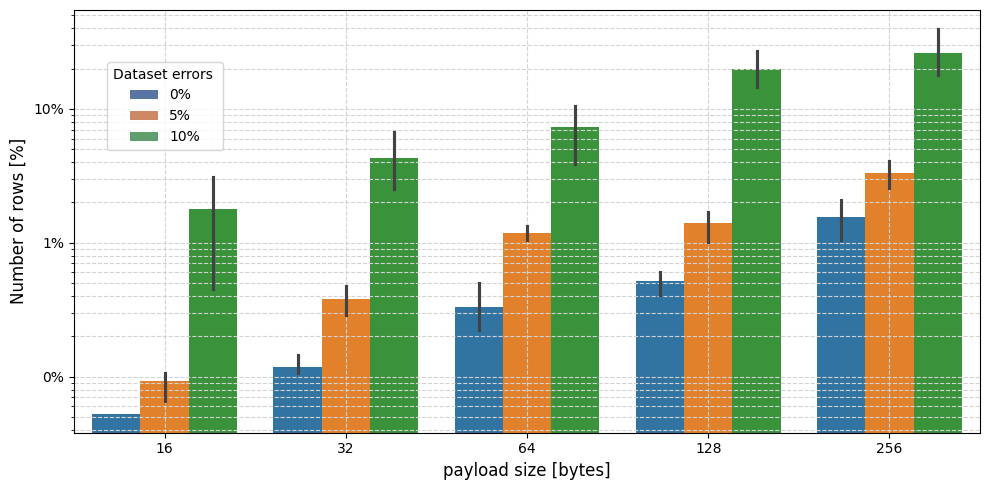

In [26]:
from matplotlib import ticker
# crop_df = pl.DataFrame(results)
# crop_df = crop_df.with_columns( (pl.col("row")  / len(begin_df)).alias("percent"))

# crop_df=crop_df.with_columns(pl.format("{} %", pl.col("error")).alias("label"))
# # sns.set_palette(["#2279B5"])

# #crop_df.write_parquet("error.parquet")

crop_df = pl.read_parquet("error.parquet")

fig, axes = plt.subplots(1,1, figsize=(10,5))


sns.barplot(x="size", y="percent", hue="label", data=crop_df, linewidth=2.5, ax=axes, legend=False)
axes.yaxis.set_major_formatter(ticker.PercentFormatter(1))
axes.set_xlabel("payload size [bytes]", fontsize=12)
axes.set_ylabel("Number of rows [%]", fontsize=12)

ticks = axes.get_xticklabels()
new_ticks = [f"{i.get_text()} bytes" for i in ticks]
#axes.set_xticklabels(new_ticks)

axes.set_yscale("log")
axes.yaxis.set_major_formatter(ticker.PercentFormatter(1))
    
#axes.set_title(f"Encoded on a dataset of {len(begin_df)} rows and 5 corrections symbols")



handles = [
    plt.Rectangle((0, 0), 1, 1, fc='#5975A4'), 
    plt.Rectangle((0, 0), 1, 1, fc='#CC8963'),
    plt.Rectangle((0, 0), 1, 1, fc='#5F9E6E')
]
labels = ["0%", "5%", "10%"]

# Ajouter la légende partagée
fig.legend( handles, labels, loc='upper center', ncol=1, title="Dataset errors ", bbox_to_anchor=(0.17, 0.88) )

#fig.suptitle(f"Minimum rows required to extract a payload ")

# #plt.grid(axis='y') 

#fig.title(f"On a dataset of {len(begin_df)} using 5 error correction symbols ", fontsize=10)
# plt.yscale('log')
# # Appliquer le formateur aux ticks X

plt.tight_layout()
axes.grid(True,which="both",ls="--",c='lightgray')  

plt.savefig("error.png")

In [177]:
ax.containers[0]

<BarContainer object of 4 artists>

In [209]:
algo.decode(stego_df)

b'D46BA891A014DE3ECEDF1D47B5AB759134E7D50D84F0CF6B5667A547207377649242368D2F1C867B0275A5D0951284A863DD38F4F0F093E6C7481484C3565508'

In [231]:
algo.decode(stego_df[:4896]) == payload

False

In [236]:
results = []

blocks = [10, 20, 50]

for b in tqdm(blocks):
    a = BitPool(bit_per_row=1, parity_size=0, block_size=b)
    stego_df = a.encode(bigdf, gen(128))
    croping_size = find_max_crop_size(a, stego_df, payload)
    
    results.append(
        {
            "block": b, 
            "data": len(payload),
            "cropping_size": croping_size
        }
    )

croping_size


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3/3 [05:25<00:00, 108.48s/it]


623027

In [68]:
a.decode(stego_df[:4000])

b''

<Axes: xlabel='block', ylabel='cropping_size'>

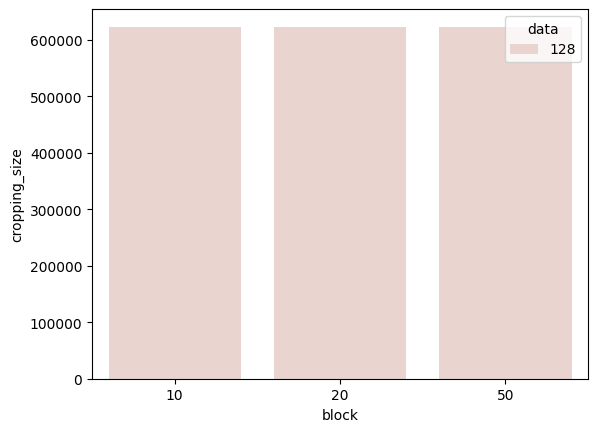

In [237]:
rdf  = pl.DataFrame(results)
rdf

sns.barplot(x="block", y="cropping_size", hue="data", data=rdf)

In [42]:
stego_data = a.decode(stego_df[:2577])
stego_data == data

True

In [7]:
from PIL import Image
from io import BytesIO
from IPython.display import display

In [86]:
a = BitPool(bit_per_row=2, block_size=5, parity_size=5)
sdf, count = a._encode(df, data)

print(count)

3592


In [50]:
a.get_packet_size() * 2714 * 8

564512

In [38]:
import matplotlib.pyplot as plt
import altair as alt

In [61]:
6 * len(df) / 100

37381.62

In [63]:
len(df) / 37381

16.666943099435542

Country,Age,Gender,Cholesterol_Level,Blood_Pressure,Smoking_History,Alcohol_Consumption,Physical_Activity,Obesity,Diabetes,Family_History,Stress_Levels,Dietary_Habits,Heart_Attack_History,Chest_Pain,Exercise_Induced_Angina,Resting_ECG,Max_Heart_Rate_Achieved,Thalassemia,HDL_Cholesterol,LDL_Cholesterol,Triglycerides,Heart_Disease_Risk,Medication_Adherence,Urbanization_Level,Air_Pollution_Exposure,Access_To_Healthcare,Education_Level,Income_Level,Heart_Attack_Outcome
str,i64,str,f64,f64,str,f64,str,str,str,str,f64,str,str,str,str,str,i64,str,f64,f64,f64,str,str,str,f64,str,str,str,str
"""United Kingdom""",41,"""Male""",159.435891,139.07524,"""Current""",0.396513,"""Moderate""","""Yes""","""No""","""No""",7.587527,"""Unhealthy""","""No""","""No""","""Yes""","""Abnormal""",77,"""Fixed Defect""",39.31504,116.952875,464.515756,"""High""","""No""","""Rural""",77.879085,"""Good""","""Primary""","""Low""","""Died"""
"""South Africa""",83,"""Male""",156.87355,112.141974,"""Former""",5.700072,"""Active""","""No""","""No""","""No""",2.759379,"""Moderate""","""Yes""","""No""","""No""","""Normal""",119,"""Fixed Defect""",54.572051,137.491595,262.677114,"""Medium""","""Yes""","""Rural""",96.631337,"""Poor""","""Tertiary""","""High""","""Survived"""
"""China""",50,"""Male""",246.722558,102.626767,"""Current""",9.087827,"""Sedentary""","""Yes""","""Yes""","""Yes""",3.137549,"""Healthy""","""Yes""","""No""","""Yes""","""Abnormal""",85,"""Reversible Defect""",39.049354,194.763097,454.668906,"""Medium""","""Yes""","""Suburban""",42.131201,"""Poor""","""Tertiary""","""Medium""","""Died"""
"""Russia""",40,"""Male""",249.13148,116.990892,"""Current""",4.394202,"""Moderate""","""Yes""","""Yes""","""Yes""",2.086069,"""Moderate""","""Yes""","""No""","""No""","""Abnormal""",148,"""Normal""",35.929851,88.843697,116.512372,"""Medium""","""No""","""Urban""",95.554379,"""Average""","""Secondary""","""Medium""","""Died"""
"""China""",65,"""Male""",284.049931,161.471981,"""Current""",8.728684,"""Active""","""Yes""","""No""","""Yes""",6.969963,"""Moderate""","""No""","""Yes""","""Yes""","""Normal""",67,"""Normal""",22.736056,171.434085,255.946483,"""High""","""Yes""","""Rural""",84.362767,"""Good""","""Primary""","""Low""","""Survived"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Egypt""",33,"""Male""",284.075687,172.783067,"""Never""",1.395931,"""Sedentary""","""Yes""","""Yes""","""No""",2.419354,"""Healthy""","""Yes""","""No""","""Yes""","""Abnormal""",61,"""Fixed Defect""",48.124838,144.698571,115.652135,"""High""","""No""","""Rural""",36.058334,"""Average""","""Tertiary""","""High""","""Died"""
"""Australia""",67,"""Female""",159.784513,86.824365,"""Never""",5.032523,"""Sedentary""","""No""","""No""","""Yes""",7.704252,"""Healthy""","""Yes""","""No""","""Yes""","""Abnormal""",157,"""Reversible Defect""",66.511509,187.156985,140.357862,"""Low""","""No""","""Rural""",12.39987,"""Average""","""Secondary""","""High""","""Died"""
"""Turkey""",72,"""Male""",197.679337,154.502756,"""Current""",7.12512,"""Moderate""","""Yes""","""No""","""No""",8.556269,"""Moderate""","""No""","""No""","""Yes""","""Normal""",68,"""Fixed Defect""",96.451441,110.020969,281.666742,"""High""","""No""","""Rural""",16.754542,"""Average""","""None""","""High""","""Died"""


In [ ]:
mdf = sdf.clone()

percent = 4
count = int(len(mdf) * (percent / 100))
index = random.sample(range(len(mdf)), count)

fdf = mdf.with_row_index().filter(~pl.col("index").is_in(index)).drop("index")

data2= a._decode(fdf)

image_data = BytesIO(data2["payload"])
# Ouvrir l'image avec Pillow
image = Image.open(image_data)
# Afficher l'image
display(image)

In [79]:
5 * len(mdf) / 100

31151.35

In [81]:
len(mdf) / 31151

20.00022471188726

In [82]:
a.get_packet_size()

26

In [83]:
20/8

2.5

In [133]:
a.get_packet_size()

21

In [38]:
df = ddf.filter(pl.col("bloc_size") == "5")

X = df["total"][50:].to_numpy().reshape(-1,1)
y = df["payload"][50:].to_numpy()


model = LinearRegression()
model.fit(X,y)

model.score(X,y)

a = model.coef_[0]
b = model.intercept_

print(a,b)


0.009071152209700253 0.6953170125900474


# Tolerance au mutation

In [41]:
1000*0.01

10.0

In [46]:
df.filter(pl.col("total") == 1700)

total,payload,bloc_size
i64,i64,str
1700,21,"""5"""
1700,18,"""5"""
1700,19,"""5"""
1700,20,"""5"""


In [5]:
df_encoded = df.to_pandas()


In [97]:
def create_deletion(mdf, percent):
    df_encoded = mdf.to_pandas()
    size = len(df_encoded)
    count = int(percent * size / 100) 
    
    index = df_encoded.sample(count).index
    df_encoded = df_encoded.drop(index)

    return pl.from_pandas(df_encoded)


    

    

In [159]:
import numpy as np

np.arange(0, 2, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [261]:
df = pl.read_csv("heart_attack_predictions.csv")
df = df.head(10000)
payload = b"se"

results = []
for p in tqdm(range(1,30,1)):
    for b in [5, 25]:
        a = BitPool(bit_per_row=1, parity_size=p, block_size=b)
        sdf = a.encode(df, payload)
        max_error = 0.0
        error  = 0.0
        while True:
            sdf = create_error(sdf, error)
            if a.decode(sdf) == payload:
                max_error = error
                error += 0.1
            else:
                break
        
        results.append({"p": p, "b": b, "error": max_error})


results = pl.DataFrame(results)


100%|█████████████████████████████████████████████████████████| 29/29 [02:58<00:00,  6.16s/it]


Text(0.5, 1.0, 'Row error tolerance based on correction code length')

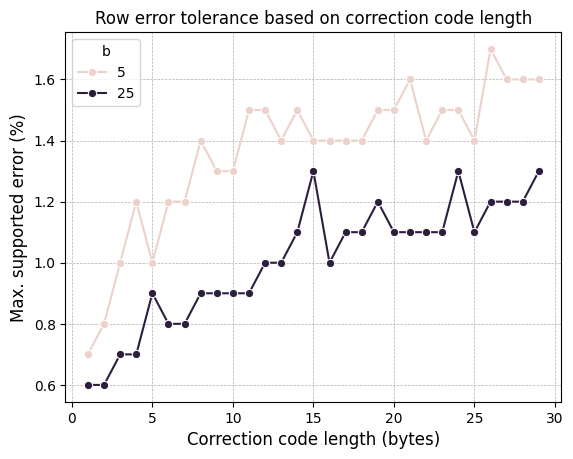

In [262]:
gdf = pl.DataFrame(results)
gdf.write_parquet("error.parquet")


sns.lineplot(x="p", y="error", hue="b", marker="o", data = gdf.to_pandas())

plt.xlabel("Correction code length (bytes)", fontsize=12)
plt.ylabel("Max. supported error (%)", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title("Row error tolerance based on correction code length")



In [47]:
df = pl.read_csv("heart_attack_predictions.csv")
df = df.head(5000)
payload = b'secret'
ntry = 5
results = []

for b in [5,25]:
    for parity in tqdm(range(1, 20, 5)):
    
        for _ in range(ntry):
            a = BitPool(bit_per_row=1, parity_size=parity, block_size=b)
            edf = a.encode(df,payload)

            for error in range(0, 100, 20):
                
                edf_error = create_error(edf, error)
                if a.decode(mdf) == payload:
                    max_error = error
                else:
                    break
        
            results.append(
                {
                    "parity": parity,
                    "error" : max_error,
                    "block": b
                }
            )





  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                   

Text(0.5, 1.0, 'Row error tolerance based on correction code length')

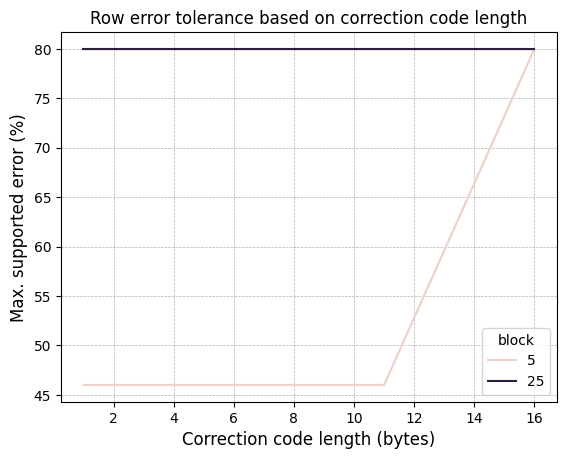

In [48]:
gdf = pl.DataFrame(results)
gdf.write_parquet("error.parquet")


sns.lineplot(x="parity", y="error", hue="block", data = gdf.to_pandas())

plt.xlabel("Correction code length (bytes)", fontsize=12)
plt.ylabel("Max. supported error (%)", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title("Row error tolerance based on correction code length")


